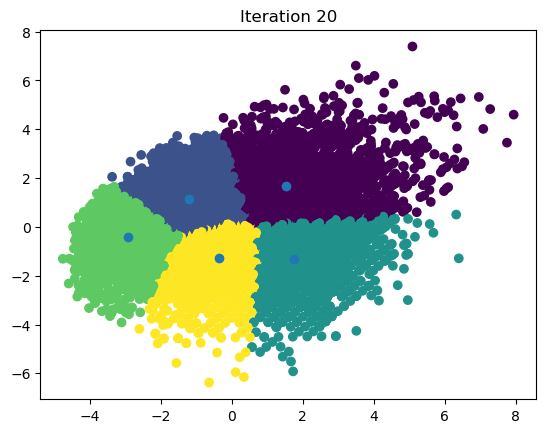

,0,1,2,3,4
overall,6.391890,4.258855,5.282375,2.479963,4.140013
potential,6.682667,5.928605,4.902506,4.388379,4.142516
wage_eur,1.637175,1.070241,1.175039,1.015592,1.052653
value_eur,1.416387,1.061649,1.058440,1.013124,1.030885
age,4.056752,2.588169,6.133074,2.305506,4.471527


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from sklearn.datasets import load_iris, load_wine

class KMeans:
    def __init__(self, k=5, max_iterations=100):
        self.k = k
        self.max_iterations = max_iterations
        self.centroids = None
        self.labels = None

    def fit(self, data):
        self.centroids = self.random_centroids(data)
        self.labels = self.get_labels(data, self.centroids)
        old_centroids = pd.DataFrame()
        iteration = 1

        while iteration <= self.max_iterations and not self.centroids.equals(old_centroids):
            old_centroids = self.centroids
            self.labels = self.get_labels(data, self.centroids)
            self.centroids = self.new_centroids(data, self.labels)
            self.plot_clusters(data, iteration)  # Plot clusters in each iteration
            iteration += 1

    def predict(self, data):
        return self.get_labels(data, self.centroids)

    def random_centroids(self, data):
        centroids = []
        for i in range(self.k):
            random.seed(42)
            centroid = data.apply(lambda x: float(x.sample().iloc[0]))
            centroids.append(centroid)
        return pd.concat(centroids, axis=1)

    def get_labels(self, data, centroids):
        distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
        return distances.idxmin(axis=1)

    def new_centroids(self, data, labels):
        return data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

    def plot_clusters(self, data, iteration):
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(data)
        centroids_2d = pca.transform(self.centroids.T)
        clear_output(wait=True)
        plt.title(f'Iteration {iteration}')
        plt.scatter(x=data_2d[:, 0], y=data_2d[:, 1], c=self.labels)
        plt.scatter(x=centroids_2d[:, 0], y=centroids_2d[:, 1])
        plt.show()



# Example usage:
players = pd.read_csv("/Users/dplavos/Desktop/MachineLearning/ML_PROJECT/archive/players_22.csv")
features = ["overall", "potential", "wage_eur", "value_eur", "age"]
players = players.dropna(subset=features)
data = players[features].copy()

# Min-max scaling # data in the range [0-10]
data = (data - data.min()) / (data.max() - data.min()) * 9 + 1

# Create KMeans object
kmeans = KMeans(k=5, max_iterations=100)

# Fit the data
kmeans.fit(data)

# Get labels for prediction
labels = kmeans.predict(data)

# Access centroids
centroids = kmeans.centroids
centroids

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(5)
kmeans.fit(data)
pd.DataFrame(kmeans.cluster_centers_, columns=features).T

/Users/dplavos/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,0,1,2,3,4
overall,4.221051,4.923779,7.082993,5.659617,2.977606
potential,4.062530,6.096043,7.276891,5.298942,4.845334
wage_eur,1.051409,1.146860,2.271323,1.267304,1.021186
value_eur,1.027512,1.095073,1.899388,1.085795,1.019103
age,4.995762,3.124719,4.348077,6.065999,2.445051
